# forecast_rental_price_of_residential

In [2]:
import os
import re
import sys
import calendar
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
import category_encoders as ce

from self_lib import tr_text as trtx
from self_lib import rpl_text
from self_lib import utils

# 可視化
from self_lib.graph import graph 

#tips
from self_lib import tips 
%matplotlib inline

# warningの無視
import warnings
warnings.filterwarnings('ignore')

# 表示列数を指定
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)

# font
plt.rcParams["font.family"] = "IPAexGothic"
## fontdict
# font = {'family'  : 'IPAexGothic',  #フォントファミリー
#         'color'   : 'navy',         #フォントカラー
#         'style'   : 'italic',       #イタリック
#         'weight'  : 'bold',         #フォントウェイト
#         'size'    : '14',           #フォントサイズ
#         'rotation': 90              # 90度回転
#         }

# 表の左寄せ表示

%%html
<style>
table {float:left}
</style>

In [3]:
# 変換リスト
df_madori=pd.DataFrame({
    '間取り':['1R',
    '1K','1DK','1DKS','1KS','1LK','1LKS','1LDK','1LDKS',
    '2K','2DK','2DKS','2KS','2LK','2LKS','2LDK','2LDKS',
    '3K','3DK','3DKS','3KS','3LK','3LKS','3LDK','3LDKS',
    '4K','4DK','4DKS','4KS','4LK','4LKS','4LDK','4LDKS',
    '5K','5DK','5DKS','5KS','5LK','5LKS','5LDK','5LDKS',
    '6K','6DK','6DKS','6KS','6LK','6LKS','6LDK','6LDKS']
})

dic_stracture={'木造': 'W', 
              '鉄骨造':'S' , '軽量鉄骨':'S' , 
              '鉄骨鉄筋コンクリート':'SRC' ,'鉄筋コンクリート':'RC' ,
              '軽量気泡コンクリート':'ALC' , 
              'プレキャスト・コンクリート':'PC' ,'重量鉄骨':'HPC' ,
               'ブロック':'B' , 'その他':'other'}

## データ読込み

In [4]:
train_raw_data = pd.read_csv('../data/train.csv')
data = pd.DataFrame(train_raw_data)

EDA

In [1]:
# data.head()

In [2]:
# data.info()

## 前処理

In [7]:
# id を削除
data=data.drop(labels='id',axis=1)

EDA

In [8]:
len(data['所在地'])

31470

In [9]:
data['所在地'].isna().sum()

0

In [10]:
i=0
for strPrefecture in data['所在地']:
    if '東京都' in strPrefecture:
        i += 1
    else:
        pass
print(i)

31470


->　欠損値なく、すべて東京都内

## 正規化処理

In [11]:
# 住所の分割
data[["都道府県", "区"]] = data['所在地'].str.split("都", expand=True)
data['都道府県'] = data['都道府県'] + "都"
data[["区", "地区"]] = data['区'].str.split("区", expand=True)
data['区'] = data['区'] + "区"

data['地区']=data['地区'] .map(trtx.zen_han)
# train_data['地区']=train_data['地区'] .map(trtx.tr_areas)

# data['地区']=data['地区'].str.replace('丁目','AoB')
data['地区']=data['地区'].str.replace('丁目','o')

data['番地']=data['地区'].str.split("o",expand=True)[1]
data['地区']=data['地区'].str.split("o",expand=True)[0]

In [12]:
# 間取りの表現を正規化
l_m=data['間取り']
l_m=l_m.map(trtx.zen_han)
l_m=l_m.str.replace("納戸","").str.replace("K\+S","KS").str.replace("\(","").str.replace("\)","")
data['間取り']=l_m

In [13]:
# 建物構造を正規化
i=0
l_s=[]
for stracture in data['建物構造']:
    type_s=rpl_text.dic_val(stracture,dic_stracture)
    l_s.append(type_s)
    i += 1
data['type']=l_s

In [14]:
# 築年数を正規化

# 年月に分割
data[['p_year','p_month']]= data['築年数'].str.split("年", expand=True)
data['p_month']=data['p_month'].str.replace('ヶ月',"")

# 新築を０年０ヶ月に変換
data['p_year']=data['p_year'].str.replace('新築',"0")
data['p_month']=data['p_month'].str.replace('新築',"0")
data['p_month']=data['p_month'].fillna('0')

# 型変換（int64）
data['p_year']=data['p_year'].astype('int64')
data['p_month']=data['p_month'].astype('int64')

In [15]:
# 面積を正規化
# 単位を削除
data['面積']=data['面積'].str.replace('m2',"")
# 型変換（float）
data['面積']=data['面積'].astype('float')

In [16]:
# 所在階を正規化
data[['階','階建て']]=data['所在階'].str.split("／", expand=True)
data['階']=data['階'].str.replace('階',"")
data['階建て']=data['階建て'].str.replace('階建',"")

In [17]:
a_data=data.copy()

In [18]:
# バス・トイレ/キッチン/放送通信を正規化

facility=["バス・トイレ","キッチン","放送・通信"]

for f in facility: 
    # 改行を削除
    a_data[f]=a_data[f].str.replace("\t","")
    
    # 表現を統一
    a_data[f]=a_data[f].str.replace("コンロ設置可（コンロ1口）","コンロ1口")
    a_data[f]=a_data[f].str.replace("コンロ設置可（コンロ2口）","コンロ2口")
    a_data[f]=a_data[f].str.replace("コンロ設置可（コンロ3口）","コンロ3口")
    a_data[f]=a_data[f].str.replace("コンロ設置可（コンロ4口以上）","コンロ4口以上")
    a_data[f]=a_data[f].str.replace("コンロ設置可（口数不明）","コンロ1口")
    
    # 分割してリストに格納
    l_facility=[]

    for word in pd.Series(a_data[f]):
        if type(word) is str:
            l_facility.append(word.split("／"))
        else: #欠損値行に欠損値を与える
            l_facility.append(np.nan)      

    # ダミー変数化
    facility = pd.Series(l_facility,name="facility")
    df=facility.str.join(sep=',').str.get_dummies(sep=',')
    a_data=pd.concat([df,a_data],axis=1)
    
    #EDA
#     print(df.sum())

In [3]:
b_data=a_data.copy()

契約期間  

|Y|定期借家|期間|
|---|---|---|
|2|Null|Null|
|2|1|2|

In [4]:
# 契約期間を正規化

# 不要文言削除
term = b_data["契約期間"].copy()
term = term.str.replace("※この物件は","")
term = term.str.replace("です。","")
term = term.str.replace("\t",";")

for word in term:
    teiki=""
    if type(word) is str:
        l_term = word.split(";")
        while '' in l_term: 
            l_term:l_term.remove('')
        
        if "定期借家" in word:
            teiki=1
#             print(l_term[1])
        else:
            pass
        
        if "まで" in word:
            target_term=l_term[0]
            target_term=target_term.replace("まで","")
            target_term=target_term.replace("年","/")
            target_term=target_term.replace("月","")
            y=pd.datetime.strptime(target_term, '%Y')
#             print(y)
            m=pd.datetime.strptime(target_term, '%m')
#             print(m)
            datetime.date(y, m, calendar.monthrange(y, m)[1])
#             print(l_term[0])
#             print(target_term)
        else:
#             print(l_term[0])
            
#         print(l_term)
    else: #欠損値行に欠損値を与える
#         l_facility.append(np.nan)
        pass
    

IndentationError: expected an indented block (<ipython-input-4-1ebb0d3586ee>, line 38)

In [5]:
b_data["契約期間"].unique()

In [110]:
# 室内設備を正規化

facility=["室内設備"]

for f in facility: 
    # 改行を削除
    b_data[f]=b_data[f].str.replace("\t"," ")
    b_data[f]=b_data[f].str.replace("／"," ")
    b_data[f]=b_data[f].str.replace("\\"," ")
    
    # 分割してリストに格納
    l_facility_room=[]

    for word in pd.Series(b_data[f]):
        if type(word) is str:
            l_facility_room.append(word.split(" "))
        else: #欠損値行に欠損値を与える
            l_facility_room.append(np.nan)      

    # ダミー変数化
    facility_r = pd.Series(l_facility_room,name="facility")
    df=facility_r.str.join(sep=',').str.get_dummies(sep=',')
    b_data=pd.concat([df,b_data],axis=1)
    
    #EDA
#     print(df.sum())

In [6]:
#EDA
b_data["アクセス"].unique()

In [112]:
c_data=b_data.copy()

In [7]:
# アクセスを正規化

# 表現を変更
c_data["アクセス"]=c_data["アクセス"].str.replace("\t\t",";")
c_data["アクセス"]=c_data["アクセス"].str.replace("\t",",")

# 分割してリストに格納
l_access=[]
for word in pd.Series(c_data["アクセス"]):
    if type(word) is str: 
        l_access.append(word.split(";"))
    else: #欠損値行に欠損値を与える
        l_facility_room.append(np.nan)
        
    # ダミー変数化
    access = pd.Series(l_access,name="access")
    df=access.str.join(sep=';').str.get_dummies(sep=';')
    c_data=pd.concat([df,c_data],axis=1)
    
    #EDA
    print(df.sum())

NameError: name 'c_data' is not defined

In [8]:
#EDA
cor_data=a_data[["賃料","コンロ1口","コンロ2口","コンロ3口","コンロ4口以上"]].copy()
cor_data=cor_data.rename(columns={"賃料":"price","コンロ1口":"C1","コンロ2口":"C2","コンロ3口":"C3","コンロ4口以上":"C4"})
sns.heatmap(cor_data.corr(),annot=True, fmt='g', cmap='coolwarm',vmin=-1,vmax=1)

NameError: name 'a_data' is not defined

-> C2,C3は賃料への影響が比較的高い  
それ以外は相関は低そう

In [34]:
#EDA
cor_data2=a_data[["賃料","コンロ1口","コンロ2口","コンロ3口","コンロ4口以上","コンロ設置可（口数不明）"]].copy()
cor_data2=cor_data2.rename(columns={"賃料":"price","コンロ1口":"C1","コンロ2口":"C2","コンロ3口":"C3","コンロ4口以上":"C4","コンロ設置可（口数不明）":"Cn"})

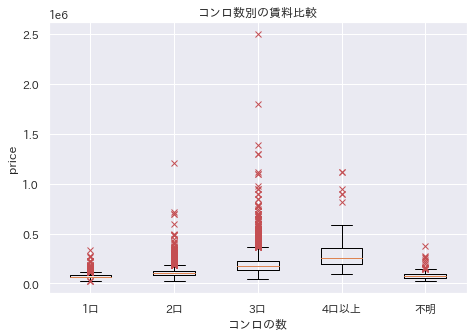

In [35]:
g=graph()
g.cmp_box(ol_vis=0,
    title="コンロ数別の賃料比較",
    x_title="コンロの数",
    y_title= "price",
    labels=["1口","2口","3口","4口以上","不明"],
    dataset=[cor_data2['price'][cor_data2['C1']==1],
    cor_data2['price'][cor_data2['C2']==1],
    cor_data2['price'][cor_data2['C3']==1],
    cor_data2['price'][cor_data2['C4']==1],
    cor_data2['price'][cor_data2['Cn']==1]])

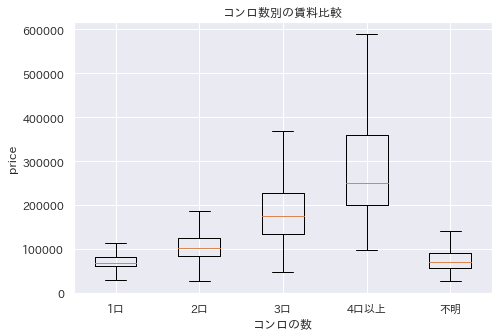

In [36]:
g=graph()
g.cmp_box(ol_vis=1,
    title="コンロ数別の賃料比較",
    x_title="コンロの数",
    y_title= "price",
    labels=["1口","2口","3口","4口以上","不明"],
    dataset=[cor_data2['price'][cor_data2['C1']==1],
    cor_data2['price'][cor_data2['C2']==1],
    cor_data2['price'][cor_data2['C3']==1],
    cor_data2['price'][cor_data2['C4']==1],
    cor_data2['price'][cor_data2['Cn']==1]])

->　不明分は１口に寄せてもよさそう

## 方針

 >  Sのあるなしで賃料がゆれているため、Sありのフラグをたてるべき
 > >OneHotEncodingで対応  
   
 > 線路/交通手段/時間で一つのカテゴリを作成する  
  
 > 階数は高いほどよいが、3F以上はエレベーターがついているかが肝

## 分析

In [26]:
c_data=data.copy()

In [27]:
def m_plot_2(x_label,label_A,label_B,Series_A,Series_B):
    """折れ線グラフ
    """
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(Series_A)
    ax.plot(Series_B)
    ax.set_xlabel(x_label)
    plt.show()

In [28]:
#賃料とtype/madoriの関係を確認する
r_data=c_data[['賃料','type','間取り']]
rg=r_data.groupby('間取り')
rg_mean=rg.mean()
rg_median=rg.median()

<AxesSubplot:>

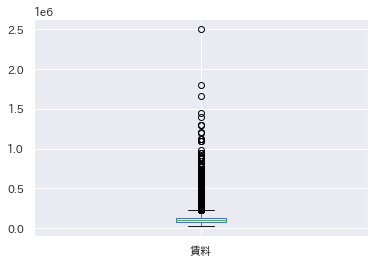

In [29]:
r_data.plot.box()

間取りでグループした場合の賃料に外れ値あり

In [ ]:
# 間取りの順序を取得する
l2=df_madori.reset_index()
l2=l2.rename(columns={'index':'order'})

In [ ]:
# mean に間取りの順序を適用する
rgl_mean=pd.merge(rg_mean,l2,on='間取り')
rgl_mean=rgl_mean.rename(columns={'賃料':'mean'})
rgl_mean=rgl_mean.sort_values('order')
rgl_mean=rgl_mean.reset_index(drop=True)
# rgl_mean

In [ ]:
# mean に間取りの順序を適用する
rgl_median=pd.merge(rg_median,l2,on='間取り')
rgl_median=rgl_median.rename(columns={'賃料':'median'})
rgl_median=rgl_median.sort_values('order')
rgl_median=rgl_median.reset_index(drop=True)
rgl_median

In [ ]:
# 表をマージする
rgl=pd.merge(rgl_mean,rgl_median,on='間取り')
rgl=rgl.sort_values('order_x')
rgl=rgl.drop(columns=['order_x','order_y'])
rgl.plot.line()
plt.show()
m_plot_2('test','mean','median',rgl_mean['mean'],rgl_median['median'])
# print(rgl)
print(rgl_median['間取り'])

In [ ]:
data.head()

In [ ]:
# 不要な列の削除
# c_data.drop(columns=['建物構造','所在地'])

In [ ]:
corr_data['madori'].unique()

In [ ]:
corr_data['madori'].value_counts()

In [ ]:
x = corr_data['madori'].value_counts().index
y = corr_data['madori'].value_counts()

graph.m_scatter_s("madori","count",x,y)

In [ ]:
# # OneHotEncoding

# #インスタンス化
# encoder = ce.OneHotEncoder(use_cat_names=True)

# # 学習
# encoder.fit(c_data.drop('madori',axis=1))

# # 変換
# d_data = encoder.transform(c_data.drop('madori',axis=1))


In [ ]:
# from sklearn.preprocessing import OneHotEncoder

# # OneHotEncoderでのencoding
# ohe =OneHotEncoder(sparse=False,categories='auto')
# ohe.fit(c_data['間取り'])

# # ダミー変数の列名作成
# columns=[]
# for i,c in enumerate('間取り'):
#     columns += [f'7{c}_{v}' for v in ohe.categories_[i]]

# # 生成されたダミー変数をデータフレームに変換
# c_data=pd.DataFrame(ohe.transform(c_data['間取り']),columns=columns)
    